In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from SAE import SparseAutoEncoder
from AE import AutoEncoder
from TopKSAE import TopKSAE
from matplotlib import pyplot as plt
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
# suppress warnings
import warnings
warnings.filterwarnings('ignore')


## Load Test Dataset

In [2]:
test_dataset = torch.load("./dataset/BATADAL_test_dataset.pt", weights_only=False)

X_test = test_dataset[0]
y_test = test_dataset[1]
input_dim = X_test.shape[1]
print(X_test.shape)


torch.Size([4177, 43])


## Autoencoder 

In [3]:
ae_model_path = f'./checkpoints/ae/2025-04-09_20-41-35/best_epoch.pth'
ae_loss_history_path = f'./checkpoints/ae/2025-04-09_20-41-35/loss_history.pkl'

In [4]:
ae_best_hyperparameters = pd.read_csv(f'./training_logs/ae/best_hyperparameters.csv')
dict_size = int(input_dim * ae_best_hyperparameters['dict_size_multiplier'][0])
ae = AutoEncoder(input_dim, dict_size)
ae_test_recon_error, ae_predicted_labels = ae.predict_anomaly(model_path=ae_model_path,
                   input_X=X_test, 
                   window=28,
                   quantile=0.95)

ae_accuracy = accuracy_score(y_test, ae_predicted_labels)
ae_f1 = f1_score(y_test, ae_predicted_labels)
ae_precision = precision_score(y_test, ae_predicted_labels)
ae_recall = recall_score(y_test, ae_predicted_labels)
print('Test Results:')
print(f"AE Accuracy: {ae_accuracy}\nF1 Score: {ae_f1}\nPrecision: {ae_precision}\nRecall: {ae_recall}")


Test Results:
AE Accuracy: 0.9549916207804644
F1 Score: 0.5607476635514018
Precision: 0.5741626794258373
Recall: 0.547945205479452


## Sparse Autoencoder

In [5]:
sae_model_path = f'./checkpoints/sae/2025-04-09_15-22-48/best_epoch.pth'
sae_loss_history_path = f'./checkpoints/sae/2025-04-09_15-22-48/loss_history.pkl'
best_hyparams_path = f'./training_logs/sae/best_hyperparameters.csv'

In [6]:
best_hyperparameters = pd.read_csv(best_hyparams_path)
dict_size = input_dim * best_hyperparameters['dict_size_multiplier'][0]
sparse_lambda = best_hyperparameters['sparse_lambda'][0]
learning_rate = best_hyperparameters['learning_rate'][0]

sae = SparseAutoEncoder(input_dim, dict_size, sparse_lambda)
sae_test_recon_loss, sae_predicted_labels = sae.predict_anomaly(model_path=sae_model_path, 
                    input_X=X_test, 
                    quantile=0.95,
                    window=28)

sae_accuracy = accuracy_score(y_test, sae_predicted_labels)
sae_f1 = f1_score(y_test, sae_predicted_labels)
sae_precision = precision_score(y_test, sae_predicted_labels)
sae_recall = recall_score(y_test, sae_predicted_labels)
print('Test Results:')
print(f"SAE Accuracy: {sae_accuracy}\nF1 Score: {sae_f1}\nPrecision: {sae_precision}\nRecall: {sae_recall}")

Test Results:
SAE Accuracy: 0.9588221211395739
F1 Score: 0.5981308411214953
Precision: 0.6124401913875598
Recall: 0.5844748858447488


## TopK SAE

In [7]:
topk_sae_model_path = f'./checkpoints/topk_sae/2025-04-09_18-19-19/best_epoch.pth'
topk_sae_loss_history_path = f'./checkpoints/topk_sae/2025-04-09_18-19-19/loss_history.pkl'
best_hyperparameters = pd.read_csv(f'./training_logs/topksae/best_hyperparameters.csv')

best_hyperparameters
dict_size = input_dim * best_hyperparameters['dict_size_multiplier'][0]
k = best_hyperparameters['k'][0]

In [8]:
topk_sae = TopKSAE(input_dim, dict_size, k)
topk_sae_recon_loss, topk_sae_predicted_labels = topk_sae.predict_anomaly(model_path=topk_sae_model_path, 
                         input_X=X_test, 
                         quantile=0.95,
                         normalize=True,
                         window=28)

topk_sae_accuracy = accuracy_score(y_test, topk_sae_predicted_labels)
topk_sae_f1 = f1_score(y_test, topk_sae_predicted_labels)
topk_sae_precision = precision_score(y_test, topk_sae_predicted_labels)
topk_sae_recall = recall_score(y_test, topk_sae_predicted_labels)
print('Test Results:')
print(f"TopK SAE Accuracy: {topk_sae_accuracy}\nF1 Score: {topk_sae_f1}\nPrecision: {topk_sae_precision}\nRecall: {topk_sae_recall}")


Test Results:
TopK SAE Accuracy: 0.9487670576969116
F1 Score: 0.5
Precision: 0.5119617224880383
Recall: 0.4885844748858447


## Figures

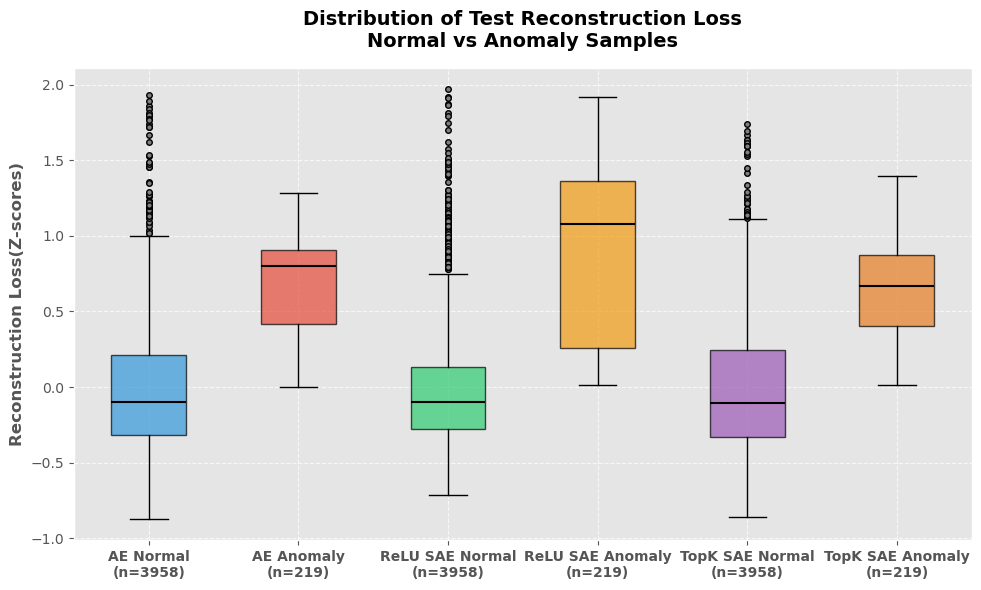

In [9]:
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

# Calculate counts
n_normal = sum(y_test == 0)
n_anomaly = sum(y_test == 1)

box_colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#e67e22'] # Added two more colors
box_plot = plt.boxplot([ae_test_recon_error[y_test == 0], ae_test_recon_error[y_test == 1],
                       sae_test_recon_loss[y_test == 0], sae_test_recon_loss[y_test == 1],
                       topk_sae_recon_loss[y_test == 0], topk_sae_recon_loss[y_test == 1]], # Added topk_sae results
                      labels=[f'AE Normal\n(n={n_normal})', f'AE Anomaly\n(n={n_anomaly})',
                             f'ReLU SAE Normal\n(n={n_normal})', f'ReLU SAE Anomaly\n(n={n_anomaly})',
                             f'TopK SAE Normal\n(n={n_normal})', f'TopK SAE Anomaly\n(n={n_anomaly})'], # Added topk_sae labels
                      patch_artist=True,
                      medianprops={'color': 'black', 'linewidth': 1.5},
                      flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'markersize': 4})

# Color the boxes
for patch, color in zip(box_plot['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Reconstruction Loss(Z-scores)', fontsize=12, fontweight='bold')
# plt.xlabel('Model Type', fontsize=12, fontweight='bold')
plt.title('Distribution of Test Reconstruction Loss\nNormal vs Anomaly Samples',
         fontsize=14, fontweight='bold', pad=15)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10)
plt.tight_layout() # Adjust layout to prevent labels overlapping


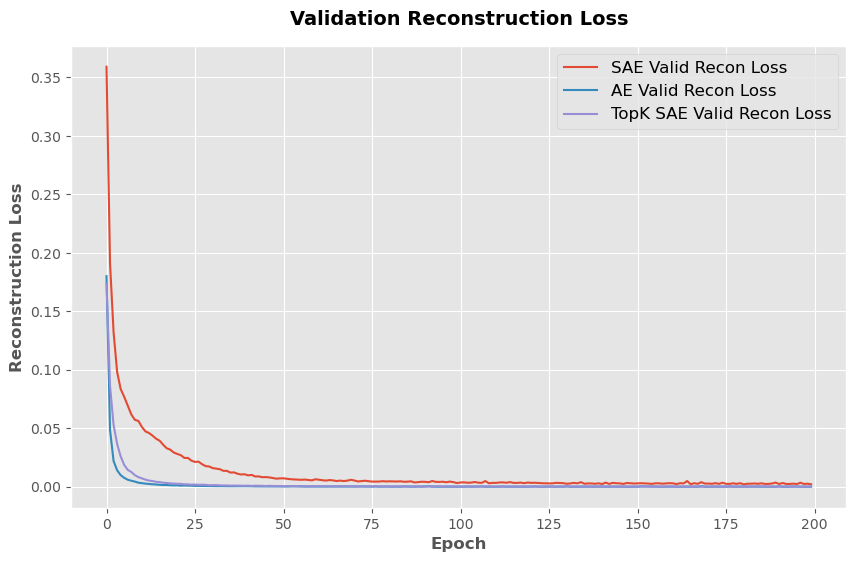

In [10]:
sae_loss_history = pickle.load(open(sae_loss_history_path, 'rb'))
ae_loss_history = pickle.load(open(ae_loss_history_path, 'rb'))
topk_sae_loss_history = pickle.load(open(topk_sae_loss_history_path, 'rb'))

# plot the train loss and valid loss of both models
plt.figure(figsize=(10, 6))
# plt.plot(sae_loss_history['train'], label='SAE Train Loss')
plt.plot(sae_loss_history['valid'], label='SAE Valid Recon Loss')
# plt.plot(ae_loss_history['train'], label='AE Train Loss')
plt.plot(ae_loss_history['valid'], label='AE Valid Recon Loss')
plt.plot(topk_sae_loss_history['valid'], label='TopK SAE Valid Recon Loss')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Reconstruction Loss', fontsize=12, fontweight='bold')
plt.title('Validation Reconstruction Loss', fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=12)  # Increase legend font size
plt.show()

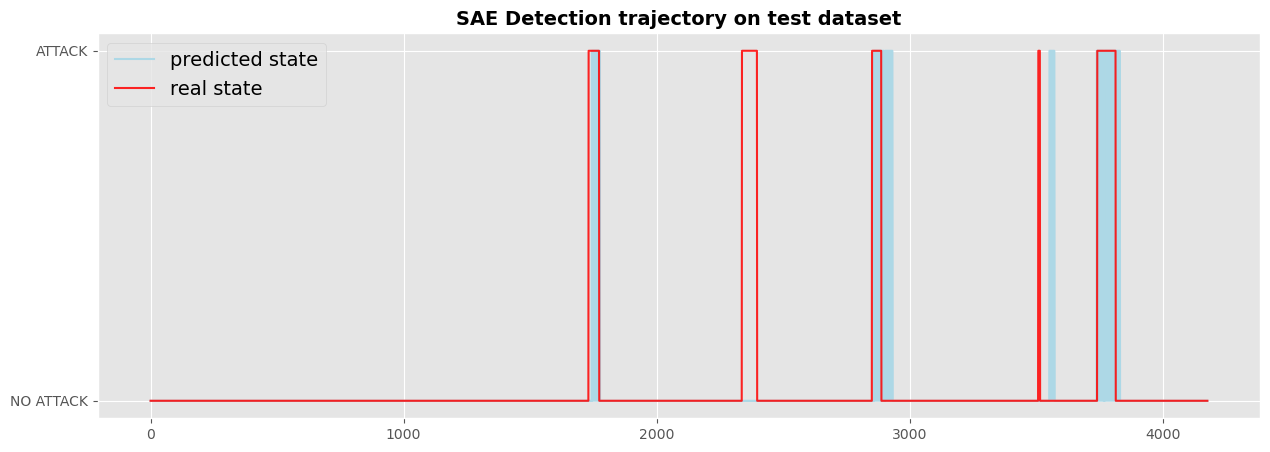

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
shade_of_gray = 'lightblue'
ax.plot(sae_predicted_labels, color=shade_of_gray, label='predicted state')
ax.fill_between(range(len(sae_predicted_labels)), sae_predicted_labels,
                where=sae_predicted_labels <= 1, interpolate=True, color=shade_of_gray)

# Plot real state  
ax.plot(y_test, color='r', alpha=0.85, lw=1.5, label='real state')

# Customize the plot
ax.set_title('SAE Detection trajectory on test dataset', fontsize=14, fontweight='bold')
ax.set_yticks([0, 1])
ax.set_yticklabels(['NO ATTACK', 'ATTACK'])
ax.legend(fontsize=14, loc=2)

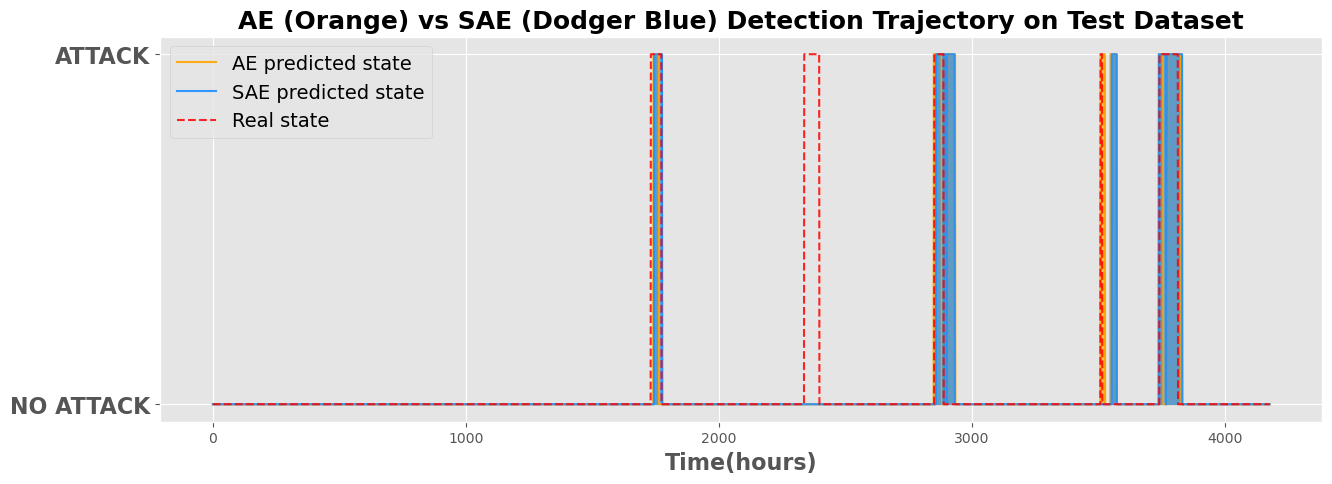

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot AE predicted state (now orange)
ae_color = 'orange' # Use orange for AE
ax.plot(ae_predicted_labels, color=ae_color, label='AE predicted state', alpha=0.9)
ax.fill_between(range(len(ae_predicted_labels)), ae_predicted_labels,
                where=ae_predicted_labels <= 1, interpolate=True, color=ae_color, alpha=0.7) # Adjusted alpha for fill

# Plot SAE predicted state (now dodgerblue)
sae_color = 'dodgerblue' # Use dodgerblue for SAE
ax.plot(sae_predicted_labels, color=sae_color, label='SAE predicted state', alpha=0.9)
ax.fill_between(range(len(sae_predicted_labels)), sae_predicted_labels,
                where=sae_predicted_labels <= 1, interpolate=True, color=sae_color, alpha=0.7) # Adjusted alpha for fill

# Plot real state
ax.plot(y_test, color='r', alpha=0.85, lw=1.5, label='Real state', linestyle='--')

# Customize the plot
ax.set_title('AE (Orange) vs SAE (Dodger Blue) Detection Trajectory on Test Dataset', fontsize=18, fontweight='bold')
ax.set_yticks([0, 1])
ax.set_yticklabels(['NO ATTACK', 'ATTACK'], fontsize=16, fontweight='bold')
ax.set_xlabel('Time(hours)', fontsize=16, fontweight='bold')
ax.legend(fontsize=14, loc=2) # Adjusted legend font size slightly for better fit

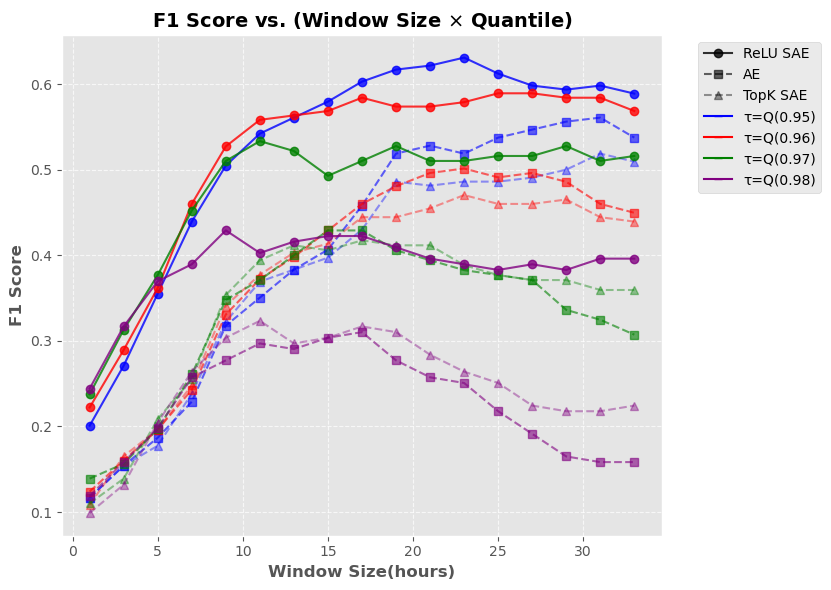

In [51]:
import matplotlib.lines as mlines

def calculate_metrics(y_true, y_pred):
    """Calculate accuracy, precision, recall and f1 score."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Test different window sizes
window_sizes = range(1, 35, 2)  # Test windows of size 1,3,5,...,19
quantiles = [0.95, 0.96, 0.97, 0.98]

# Dictionary to store F1 scores for each quantile
sae_f1_scores_dict = {q: [] for q in quantiles}
ae_f1_scores_dict = {q: [] for q in quantiles}
topk_sae_f1_scores_dict = {q: [] for q in quantiles}

for window in window_sizes:
    for quantile in quantiles:
        # Get predictions with current window size for SAE
        recon_loss, predicted_labels = sae.predict_anomaly(
            model_path=sae_model_path,
            input_X=X_test,
            quantile=quantile,
            window=window
        )
        
        # Calculate metrics for SAE
        _, _, _, f1 = calculate_metrics(y_test, predicted_labels.cpu().numpy())
        sae_f1_scores_dict[quantile].append(f1)
        
        # Get predictions with current window size for AE
        recon_loss, predicted_labels = ae.predict_anomaly(
            model_path=ae_model_path,
            input_X=X_test,
            quantile=quantile,
            window=window
        )
        
        # Calculate metrics for AE
        _, _, _, f1 = calculate_metrics(y_test, predicted_labels.cpu().numpy())
        ae_f1_scores_dict[quantile].append(f1)

        # get predictions with current window size for TopK SAE
        recon_loss, predicted_labels = topk_sae.predict_anomaly(
            model_path=topk_sae_model_path,
            input_X=X_test,
            quantile=quantile,
            normalize=True,
            window=window
        )
        # Calculate metrics for TopK SAE
        _, _, _, f1 = calculate_metrics(y_test, predicted_labels.cpu().numpy())
        topk_sae_f1_scores_dict[quantile].append(f1)
        

# Plot F1 scores vs window size for different quantiles
plt.figure(figsize=(10, 6))

# Define colors for each quantile
colors = ['blue', 'red', 'green', 'purple']
model_markers = {'ReLU SAE': 'o', 'AE': 's', 'TopK SAE': '^'}
model_linestyles = {'ReLU SAE': '-', 'AE': '--', 'TopK SAE': '--'}
model_alphas = {'ReLU SAE': 0.8, 'AE': 0.6, 'TopK SAE': 0.4}

# Plot results for each quantile
for i, quantile in enumerate(quantiles):
    # Plot SAE
    plt.plot(window_sizes, sae_f1_scores_dict[quantile], 
             color=colors[i], alpha=model_alphas['ReLU SAE'],
             marker=model_markers['ReLU SAE'], linestyle=model_linestyles['ReLU SAE'])
    
    # Plot AE
    plt.plot(window_sizes, ae_f1_scores_dict[quantile], 
             color=colors[i], alpha=model_alphas['AE'],
             marker=model_markers['AE'], linestyle=model_linestyles['AE'])
    
    # Plot TopK SAE
    plt.plot(window_sizes, topk_sae_f1_scores_dict[quantile], 
             color=colors[i], alpha=model_alphas['TopK SAE'],
             marker=model_markers['TopK SAE'], linestyle=model_linestyles['TopK SAE'])

plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Window Size(hours)', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12, fontweight='bold')
plt.title('F1 Score vs. (Window Size $\\times$ Quantile)', fontsize=14, fontweight='bold')

# Create custom legend handles
model_handles = [mlines.Line2D([], [], color='black', marker=model_markers[model], 
                               linestyle=model_linestyles[model], alpha=model_alphas[model], 
                               label=model) 
                 for model in model_markers]
quantile_handles = [mlines.Line2D([], [], color=colors[i], marker='_', linestyle='-', 
                                  label=f'τ=Q({quantile})') 
                    for i, quantile in enumerate(quantiles)]

# Combine handles and create legend
plt.legend(handles=model_handles + quantile_handles, 
           fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()


## Interpretability Analysis

In [19]:
# index of attack in the test dataset 1731:1772
# Extract attack period from test data
first_attack_period = X_test[1731:1772]
print(f"First attack period shape: {first_attack_period.shape}")
sae_C_scores = sae.calculate_feature_contribution(first_attack_period, sae_model_path,
                                              decoder_only=False)
ae_C_scores = ae.calculate_feature_contribution(first_attack_period, ae_model_path,
                                              decoder_only=False)
print(f"C_scores shape: {sae_C_scores.shape}")

# load the csv file
test_data_csv = pd.read_csv('./dataset/BATADAL_test_dataset.csv')
features = [col for col in test_data_csv.columns if col not in ['DATETIME','ATT_FLAG']]
feature_mapping = {feature: i for i, feature in enumerate(features)}

First attack period shape: torch.Size([41, 43])


C_scores shape: torch.Size([43])


### SAE Contribution Scores 

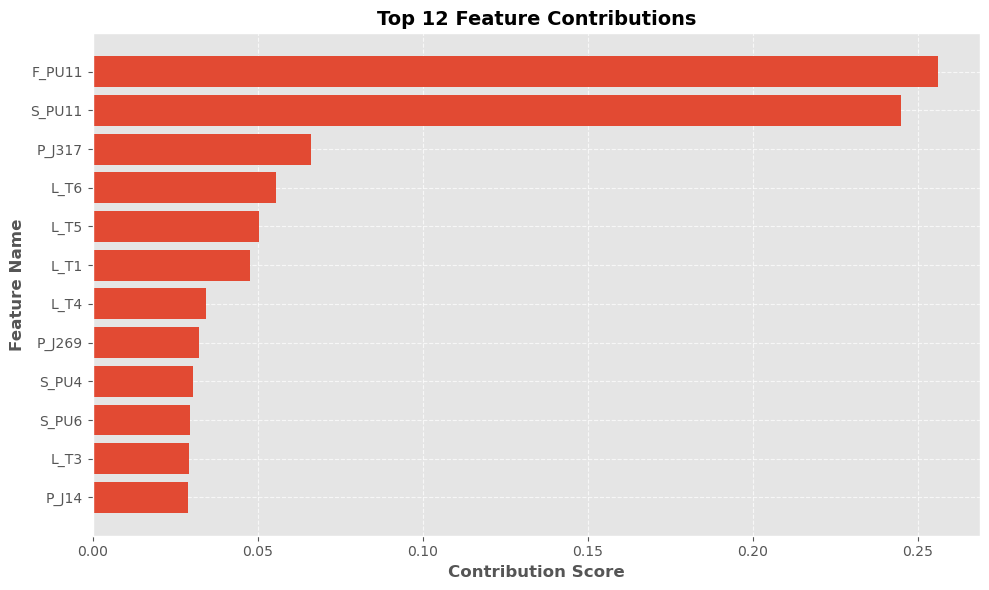

In [20]:
# Sort C_scores and get indices of top 10
topk = 12
top_10_indices = torch.argsort(sae_C_scores, descending=True)[:topk]
top_10_scores = sae_C_scores[top_10_indices]

# Map indices to feature names
feature_names = [list(feature_mapping.keys())[i] for i in top_10_indices]

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(topk)[::-1], top_10_scores)  # Reverse the range to plot highest scores on top
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Feature Name', fontsize=12, fontweight='bold')
plt.xlabel('Contribution Score', fontsize=12, fontweight='bold')
plt.title(f'Top {topk} Feature Contributions', fontsize=14, fontweight='bold')

# Add feature names as y-tick labels, reversed to match the plot
plt.yticks(range(topk)[::-1], feature_names)

plt.tight_layout()
plt.show()

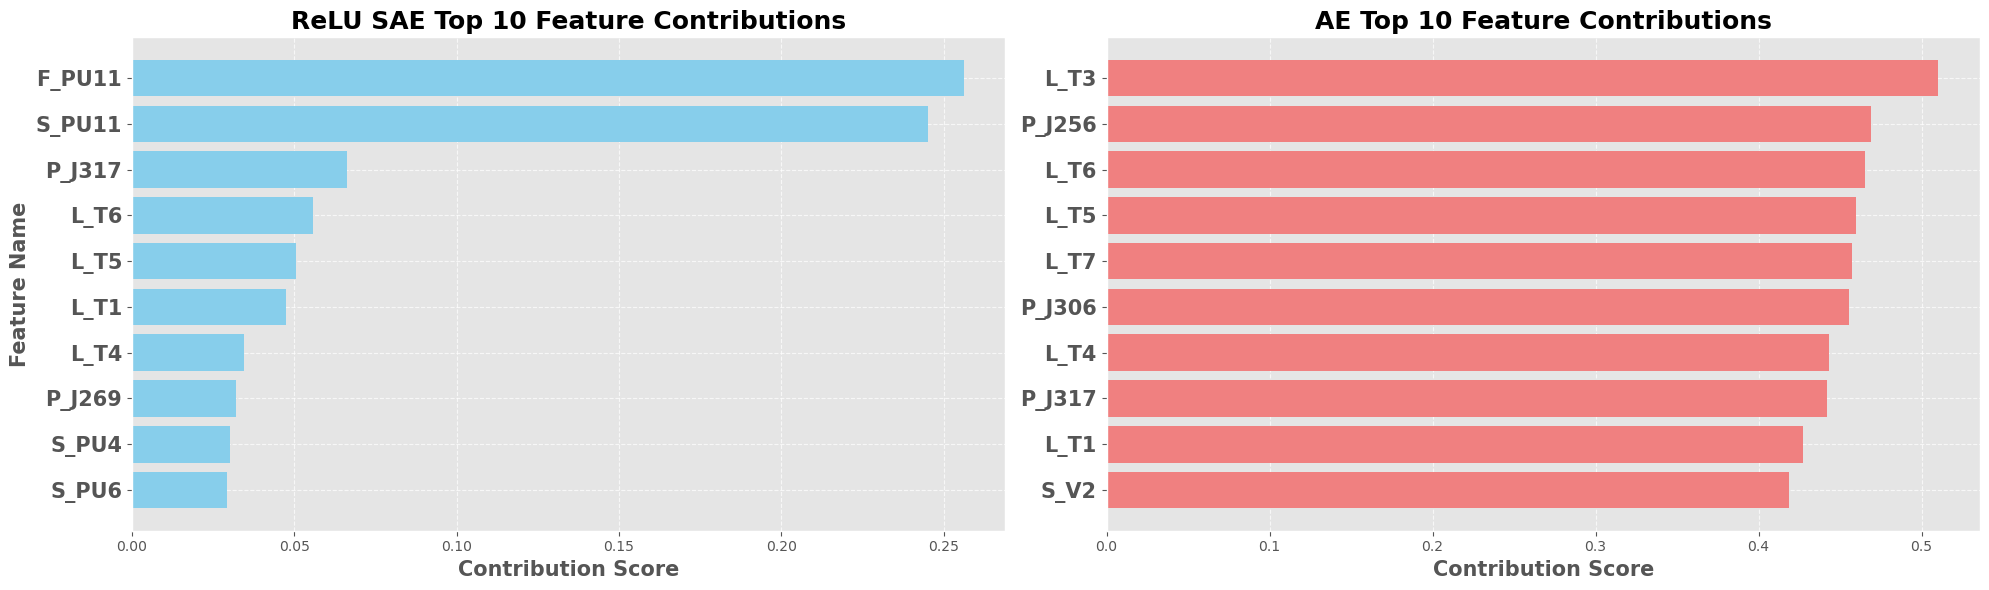

In [37]:
# Define top K
topk = 10

# --- SAE Data ---
# Sort SAE C_scores and get indices/scores of top K
sae_top_indices = torch.argsort(sae_C_scores, descending=True)[:topk]
sae_top_scores = sae_C_scores[sae_top_indices]
# Map indices to feature names for SAE
sae_feature_names = [list(feature_mapping.keys())[i] for i in sae_top_indices]

# --- AE Data ---
# Sort AE C_scores and get indices/scores of top K
ae_top_indices = torch.argsort(ae_C_scores, descending=True)[:topk]
ae_top_scores = ae_C_scores[ae_top_indices]
# Map indices to feature names for AE
ae_feature_names = [list(feature_mapping.keys())[i] for i in ae_top_indices]

# --- Create Subplots ---
fig, axes = plt.subplots(1, 2, figsize=(20, 6)) # 1 row, 2 columns

# --- Plot SAE (Left Subplot) ---
axes[0].barh(range(topk)[::-1], sae_top_scores, color='skyblue') # Reverse range for highest on top
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_ylabel('Feature Name', fontsize=15, fontweight='bold')
axes[0].set_xlabel('Contribution Score', fontsize=15, fontweight='bold')
axes[0].set_title(f'ReLU SAE Top {topk} Feature Contributions', fontsize=18, fontweight='bold')
# Add feature names as y-tick labels, reversed
axes[0].set_yticks(range(topk)[::-1])
axes[0].set_yticklabels(sae_feature_names, fontweight='bold', fontsize=15)

# --- Plot AE (Right Subplot) ---
axes[1].barh(range(topk)[::-1], ae_top_scores, color='lightcoral') # Reverse range, different color
axes[1].grid(True, linestyle='--', alpha=0.7)
# axes[1].set_ylabel('Feature Name', fontsize=12, fontweight='bold') # Y-label might be redundant if shared
axes[1].set_xlabel('Contribution Score', fontsize=15, fontweight='bold')
axes[1].set_title(f'AE Top {topk} Feature Contributions', fontsize=18, fontweight='bold')
# Add feature names as y-tick labels, reversed
axes[1].set_yticks(range(topk)[::-1])
axes[1].set_yticklabels(ae_feature_names, fontweight='bold', fontsize=15)


# --- Final Adjustments ---
plt.tight_layout() # Adjust layout to prevent overlap
plt.show()